In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [3]:
# Load Data
florida = pd.read_csv('florida_file_.csv')
print(florida.head())
print(florida.tail(5))
florida["Date"] = pd.to_datetime(florida["Date"])

florida = florida[["Date", "Avg_Temp"]]
florida = florida.fillna(florida.bfill())
florida.columns = ['Date', 'Avg_Temp']

train = florida[:-225]
print(len(train))
test = florida[-225:]
print(len(test))
train_dates = pd.to_datetime(train['Date'])
test_dates  = pd.to_datetime(test['Date'])

        Date  Avg_Temp  confidence_interval_temp    State        Country  \
0  11/1/1743    17.694                     2.514  Florida  United States   
1  12/1/1743    22.978                     2.470  Florida  United States   
2   1/1/1744    22.978                     2.470  Florida  United States   
3   2/1/1744    22.978                     2.470  Florida  United States   
4   3/1/1744    22.978                     2.470  Florida  United States   

   Year  Month  Day  
0  1743     11    1  
1  1743     12    1  
2  1744      1    1  
3  1744      2    1  
4  1744      3    1  
          Date  Avg_Temp  confidence_interval_temp    State        Country  \
3234  5/1/2013    23.576                     0.188  Florida  United States   
3235  6/1/2013    27.432                     0.201  Florida  United States   
3236  7/1/2013    27.327                     0.280  Florida  United States   
3237  8/1/2013    28.188                     0.334  Florida  United States   
3238  9/1/2013    27.

In [19]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['Avg_Temp'].values.reshape(-1,1))

prediction_days = 225

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape, y_train.shape)
print(scaled_data)
print(x_train)
print(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

(2789, 225) (2789,)
[[0.33366918]
 [0.5651393 ]
 [0.5651393 ]
 ...
 [0.58708603]
 [0.50394253]
 [0.31623445]]
[[0.33366918 0.5651393  0.5651393  ... 0.60070965 0.7469774  0.79586473]
 [0.5651393  0.5651393  0.5651393  ... 0.7469774  0.79586473 0.64328894]
 [0.5651393  0.5651393  0.5651393  ... 0.79586473 0.64328894 0.64328894]
 ...
 [0.13759418 0.29533906 0.45755213 ... 0.74894866 0.74307868 0.69887857]
 [0.29533906 0.45755213 0.47551253 ... 0.74307868 0.69887857 0.58708603]
 [0.45755213 0.47551253 0.59330647 ... 0.69887857 0.58708603 0.50394253]]
[0.64328894 0.64328894 0.44581216 ... 0.58708603 0.50394253 0.31623445]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 225, 128)          66560     
                                                                 
 dropout_3 (Dropout)         (None, 225, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 225, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 225, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

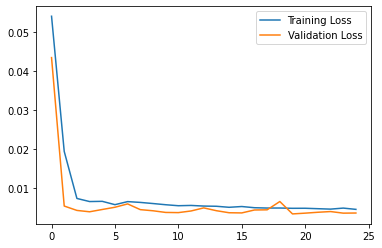

In [5]:
# Build The Model
model = Sequential()

model.add(LSTM(units =128, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

## Need to figure out how the data size and the batch_size work ... need to optimize for a GPU system.  Higher batch size works much better on the GPU (less overhead)
history = model.fit(x_train, y_train, epochs = 25, batch_size=32, validation_split=0.1)


plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [20]:
### Test the Model Accuracy on Existing Data ###
################################################

# take Test data Again
test.head()
actual_temp = test['Avg_Temp'].values
total_temp = pd.concat((train['Avg_Temp'], test['Avg_Temp']),axis=0)

model_inputs = total_temp[len(total_temp)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)
print(model_inputs.shape)

# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

pred = model.predict(x_test)
print('Predictions:\n', pred[:][:10])
pred = scaler.inverse_transform(pred)
print('Inverse Transformed Predictions\n', pred[:][:10])

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test['Avg_Temp'], pred)

(450, 1)
(225, 225, 1)


NameError: name 'model' is not defined

C:\Users\elisertech\.venv\testing\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\elisertech\.venv\testing\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


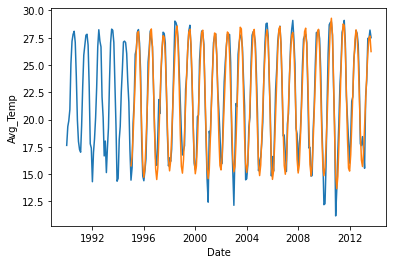

In [8]:
### Visualization ###
#####################
pred_ = pd.DataFrame(test['Date'])
pred_['Avg_Temp'] = pred
pred_["Date"] = pd.to_datetime(pred_["Date"])

pred_
original = florida.loc[florida['Date'] >= '1990-01-01']

import seaborn as sns
sns.lineplot(original['Date'], original['Avg_Temp'])
sns.lineplot(pred_['Date'], pred_['Avg_Temp'])
plt.show()